In [57]:
from configs.RecursiveVPSDE.recursive_fOU_T256_H07_tl_5data import get_config
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSScoreMatching import \
    ConditionalLSTMTSScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassNaiveMLP import NaiveMLP
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion

In [58]:
config = get_config()
assert (0 < config.hurst < 1.)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 5)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalLSTMTSScoreMatching(
    *config.model_parameters) if config.model_choice == "TSM" else NaiveMLP(
    *config.model_parameters)
train_epoch = 6920
scoreModel.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(train_epoch)))
N = 1000
data_shape = (N, 1, 1)
device = "cpu"
diff_time_scale = torch.linspace(start=config.end_diff_time, end=config.sample_eps,
                                   steps=config.max_diff_steps)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
ts_step = 1/config.ts_length

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5 40000


In [59]:
# real time 0
prev_path = torch.zeros(size=(data_shape[0], 1, data_shape[-1])).to(device)
feature, (h, c) = scoreModel.rnn(prev_path, None) # Feature for real time 0
tau = diff_time_scale[900] * torch.ones((data_shape[0],)).to(device) # End of reverse-diffusion

In [60]:
# Create a linear sequence of "corrupted samples"
diffusion_mean2 = torch.atleast_2d(torch.exp(-diffusion.get_eff_times(diff_times=tau))).T.to(device)
diffusion_var = 1. - diffusion_mean2
exp_mean = torch.sqrt(diffusion_mean2)*(ts_step)*(-0.8*prev_path.squeeze(-1))
assert(exp_mean.shape == prev_path.squeeze(-1).shape)
exp_var = diffusion_var+diffusion_mean2*(ts_step)
Xtaus = torch.sort(torch.normal(mean=exp_mean, std=torch.sqrt(exp_var)).reshape((N, data_shape[1],1)), dim=0)[0]

0.99447316 tensor([[0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9999],

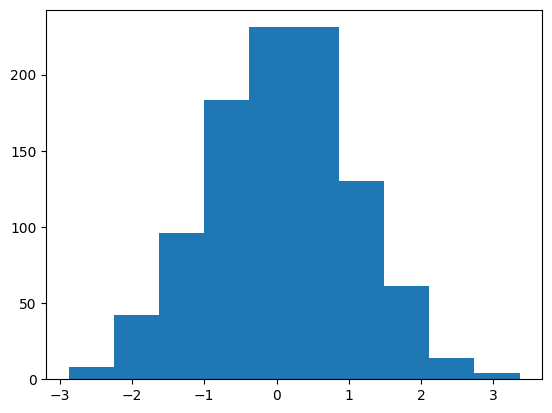

In [61]:
plt.hist(Xtaus.squeeze())
print(np.std(Xtaus.squeeze().numpy()),torch.sqrt(exp_var))

In [62]:
print(Xtaus.shape, tau.shape, feature.shape)
with torch.no_grad():
    score_evals = scoreModel.forward(inputs=Xtaus, times=tau, conditioner=feature)

torch.Size([1000, 1, 1]) torch.Size([1000]) torch.Size([1000, 1, 20])


<>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_1412/1613833349.py:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(Xtaus.shape == (data_shape[0],1,1), score_evals.shape==(data_shape[0],1,1))


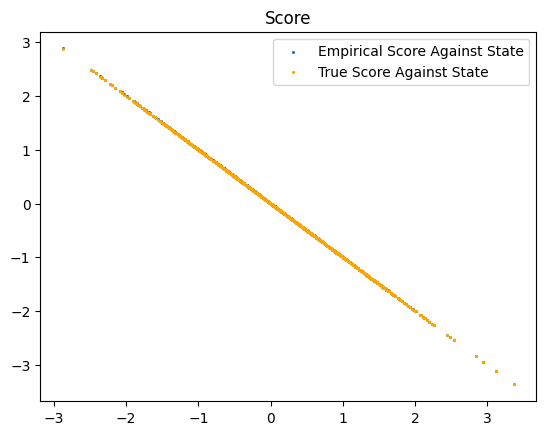

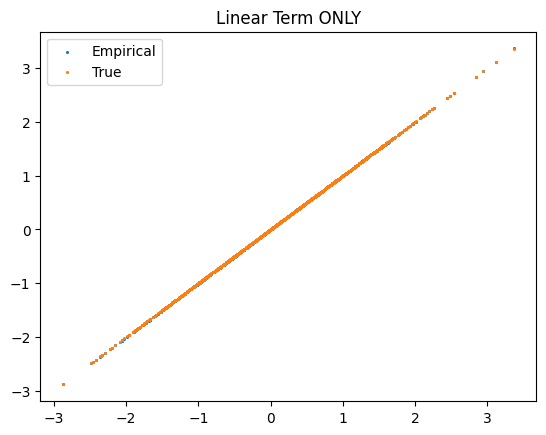

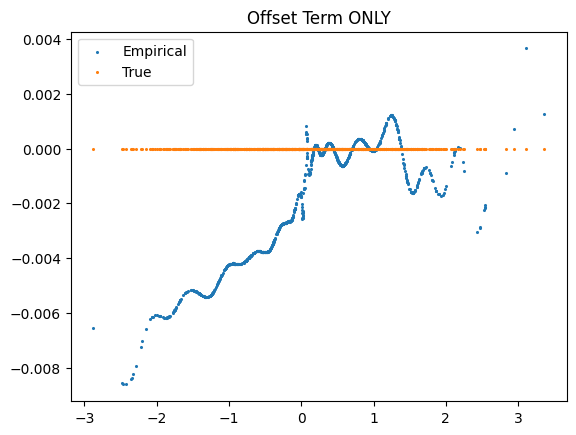

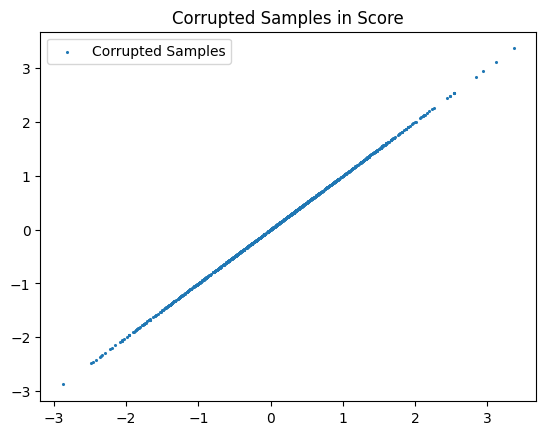

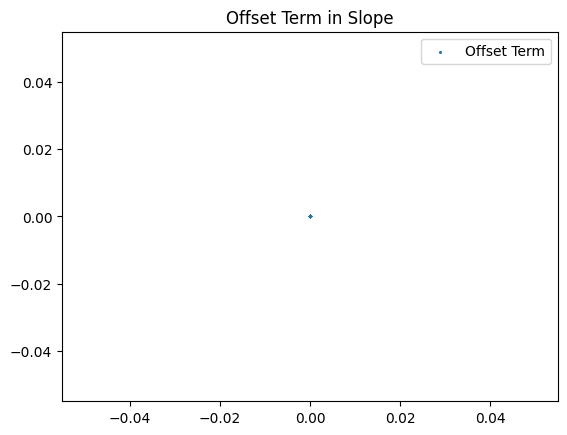

In [63]:
def check_linear_score(config,Xtaus, score_evals, diffusion_var, diffusion_mean2, ts_step, prev_path):
    assert(Xtaus.shape == (data_shape[0],1,1), score_evals.shape==(data_shape[0],1,1))
    plt.scatter(Xtaus.squeeze(), score_evals.squeeze(), label="Empirical Score Against State", s=1.5)
    exp_slope = -(1/((diffusion_var + diffusion_mean2 * ts_step))[0])
    exp_const = torch.sqrt(diffusion_mean2)*(ts_step)*(-config.mean_rev*prev_path.squeeze(-1))
    plt.scatter(Xtaus.squeeze(-1), exp_slope*(Xtaus.squeeze(-1)-exp_const), color="orange", label="True Score Against State", s=1.5)
    plt.title("Score")
    plt.legend()
    plt.show()
    plt.close()
    plt.scatter(Xtaus.squeeze(),score_evals.squeeze(-1)/exp_slope, label="Empirical", s=1.5)
    plt.scatter(Xtaus.squeeze(),Xtaus.squeeze(-1)-exp_const, label="True", s=1.5)
    plt.title("Linear Term ONLY")
    plt.legend()
    plt.show()
    plt.close()
    plt.scatter(Xtaus.squeeze(),-Xtaus.squeeze(-1)+score_evals.squeeze(-1)/exp_slope, label="Empirical", s=1.5)
    plt.scatter(Xtaus.squeeze(),-exp_const, label="True", s=1.5)
    plt.title("Offset Term ONLY")
    plt.legend()
    plt.show()
    plt.close()
    plt.scatter(Xtaus.squeeze(),Xtaus.squeeze(), label="Corrupted Samples",s=1.5)
    plt.title("Corrupted Samples in Score")
    plt.legend()
    plt.show()
    plt.close()
    plt.scatter(exp_const,exp_const, label="Offset Term", s=1.5)
    plt.title("Offset Term in Slope")
    plt.legend()
    plt.show()
    plt.close()
check_linear_score(config=config,Xtaus=Xtaus, score_evals=score_evals, diffusion_var=diffusion_var,diffusion_mean2=diffusion_mean2,ts_step=ts_step, prev_path=prev_path)

torch.Size([1000, 1]) torch.Size([1]) torch.Size([1000, 1, 1]) torch.Size([1000, 1, 1])


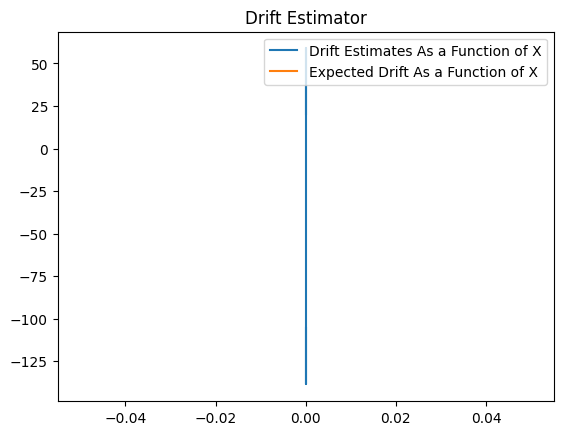

tensor([[ 1.0538e+02],
        [ 1.3804e+02],
        [ 1.3859e+02],
        [ 1.3866e+02],
        [ 1.3569e+02],
        [ 1.3464e+02],
        [ 1.3269e+02],
        [ 1.2771e+02],
        [ 1.1682e+02],
        [ 1.1332e+02],
        [ 1.0605e+02],
        [ 1.0045e+02],
        [ 9.8895e+01],
        [ 9.8848e+01],
        [ 9.8734e+01],
        [ 9.7920e+01],
        [ 9.7846e+01],
        [ 9.8166e+01],
        [ 9.8238e+01],
        [ 9.8289e+01],
        [ 9.8291e+01],
        [ 9.9148e+01],
        [ 9.9305e+01],
        [ 9.9395e+01],
        [ 9.9371e+01],
        [ 9.9344e+01],
        [ 9.9277e+01],
        [ 9.9111e+01],
        [ 9.8781e+01],
        [ 9.8691e+01],
        [ 9.8254e+01],
        [ 9.6438e+01],
        [ 9.6049e+01],
        [ 9.5387e+01],
        [ 9.5211e+01],
        [ 9.5123e+01],
        [ 9.4949e+01],
        [ 9.4754e+01],
        [ 9.4586e+01],
        [ 9.3619e+01],
        [ 9.3150e+01],
        [ 9.1400e+01],
        [ 9.0094e+01],
        [ 8

In [67]:
# Build drift estimator
def build_drift_estimator(config,diffusion_var, diffusion_mean2, ts_step, score_evals, Xtaus, prev_path):
    c1 = ((diffusion_var + diffusion_mean2 * ts_step) / (torch.pow(diffusion_mean2, 0.5))[0])
    c2 = (torch.pow(diffusion_mean2, -0.5))[0]
    print(c1.shape, c2.shape, score_evals.shape, Xtaus.shape)
    mean_est = c1 * score_evals.squeeze(-1) + c2 * Xtaus.squeeze(-1)
    mean_est /= ts_step
    plt.plot(prev_path.squeeze(),-mean_est, label="Drift Estimates As a Function of X")
    plt.plot(prev_path.squeeze(),-config.mean_rev*prev_path.squeeze(), label="Expected Drift As a Function of X")
    plt.title("Drift Estimator")
    plt.legend()
    plt.plot()
    plt.show()
    plt.close()
    return mean_est
build_drift_estimator(config=config,diffusion_var=diffusion_var, diffusion_mean2=diffusion_mean2, ts_step=ts_step, score_evals=score_evals, Xtaus=Xtaus, prev_path=prev_path)

In [68]:
def single_time_sampling(config, diff_time_space, diffusion, feature, scoreModel, device, prev_path):
    x = diffusion.prior_sampling(shape=data_shape).to(device)  # Move to correct device
    for diff_index in tqdm(range(config.max_diff_steps)):
        tau = diff_time_space[diff_index]*torch.ones((data_shape[0],)).to(device)
        score, drift, diffParam = diffusion.get_conditional_reverse_diffusion(x=x, t=tau,
                                                                                  feature=feature,
                                                                                  score_network=scoreModel,
                                                                                  diff_index=torch.Tensor([int(diff_index)]).to(device),
                                                                                  max_diff_steps=config.max_diff_steps)
        if diff_index == 9999:
            diffusion_mean2 = torch.atleast_2d(torch.exp(-diffusion.get_eff_times(diff_times=tau))).T.to(device)
            diffusion_var = 1. - diffusion_mean2
            check_linear_score(config=config,Xtaus=x, score_evals=score, diffusion_var=diffusion_var, diffusion_mean2=diffusion_mean2, ts_step=ts_step, prev_path=prev_path)
            mean_est = build_drift_estimator(config=config,diffusion_var=diffusion_var, diffusion_mean2=diffusion_mean2, ts_step=ts_step, score_evals=score, Xtaus=x, prev_path=prev_path)
        z = torch.randn_like(drift)
        x = drift + diffParam * z
    return x, mean_est

In [69]:
def evaluate_ts_marginal_histogram(samples, ts_time, config, train_epoch):
    expmeanrev = np.exp(-config.mean_rev * ts_time)
    exp_mean = config.mean * (1. - expmeanrev)
    exp_mean += config.initState * expmeanrev
    exp_var = np.power(config.diffusion, 2)
    exp_var /= (2 * config.mean_rev)
    exp_var *= 1. - np.power(expmeanrev, 2)
    exp_rvs = np.random.normal(loc=exp_mean, scale=np.sqrt(exp_var), size=samples.shape[0])
    plt.hist(samples.squeeze(), bins=150, density=True, label="True")
    plt.hist(exp_rvs, bins=150, density=True, label="Expected")
    plt.title(f"Marginal Distributions at time {ts_time} for epoch {train_epoch}")
    plt.legend()
    plt.show()
    plt.close()
def evaluate_per_time_samples(samples, ts_time, train_epoch,config=config):
    try:
        assert(samples.shape == (data_shape[0],1))
    except AssertionError:
        samples = samples.squeeze(-1)
    evaluate_ts_marginal_histogram(samples=samples, ts_time=ts_time, train_epoch=train_epoch,config=config)


In [70]:
def run_whole_ts_recursive_diffusion(config, initial_feature_input, diffusion, scoreModel, device, diff_time_scale, real_time_scale):
    samples = initial_feature_input
    for t in (range(config.ts_length)):
        print("Sampling at real time {}\n".format(t + 1))
        if t == 0:
            feature, (h, c) = scoreModel.rnn(samples, None)
        else:
            feature, (h, c) = scoreModel.rnn(samples, (h, c))
        new_samples, mean = single_time_sampling(config=config,diff_time_space=diff_time_scale, diffusion=diffusion, scoreModel=scoreModel, device=device, feature=feature, prev_path=samples)
        cumsumsamples = new_samples + samples # For evaluation, we need path, not increment
        samples = new_samples # But we feed latest increment to the LSTM
        evaluate_per_time_samples(samples=cumsumsamples,  ts_time=real_time_scale[t], train_epoch=train_epoch)

Sampling at real time 1



100%|█████████▉| 9997/10000 [15:15<00:00, 47.20it/s]   

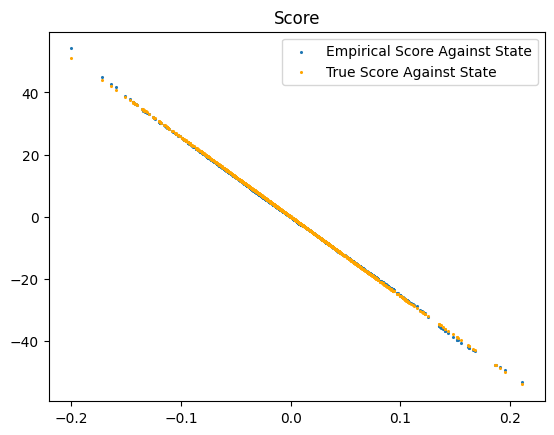

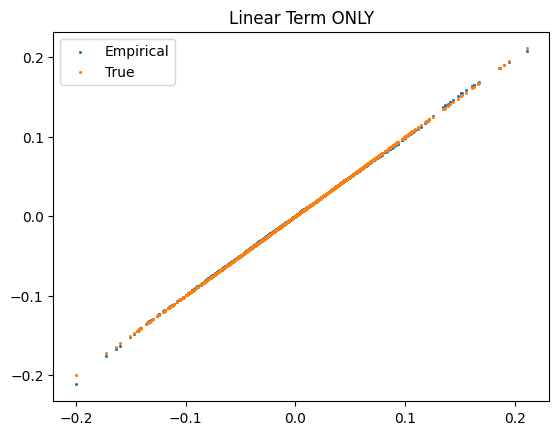

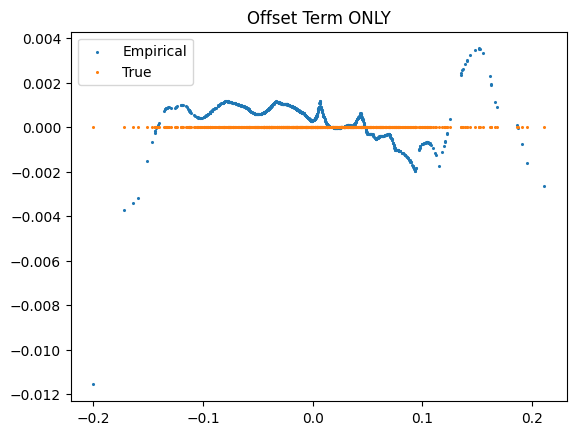

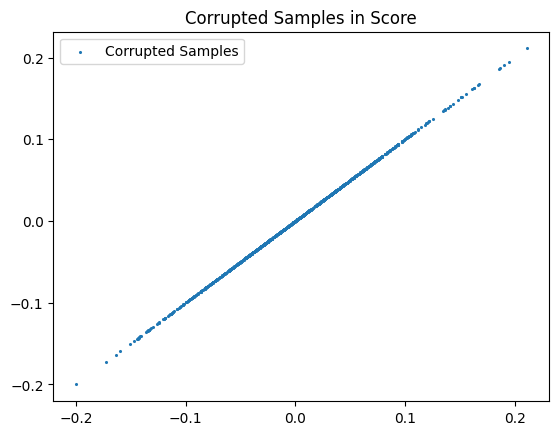

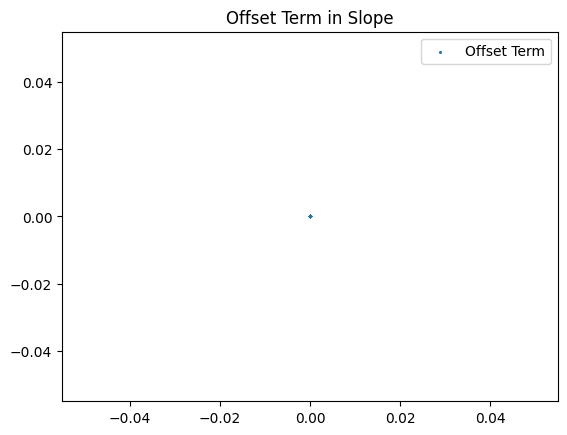

torch.Size([1000, 1]) torch.Size([1]) torch.Size([1000, 1, 1]) torch.Size([1000, 1, 1])


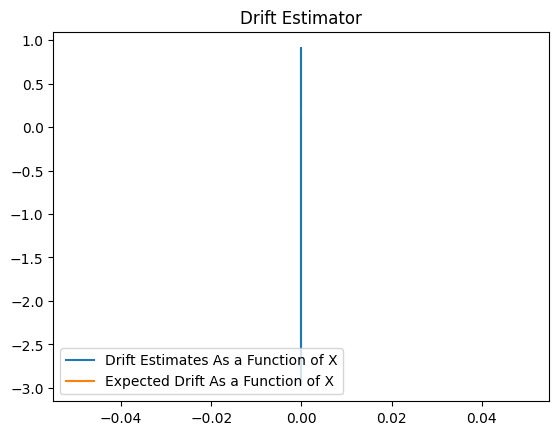

100%|██████████| 10000/10000 [15:16<00:00, 10.91it/s]


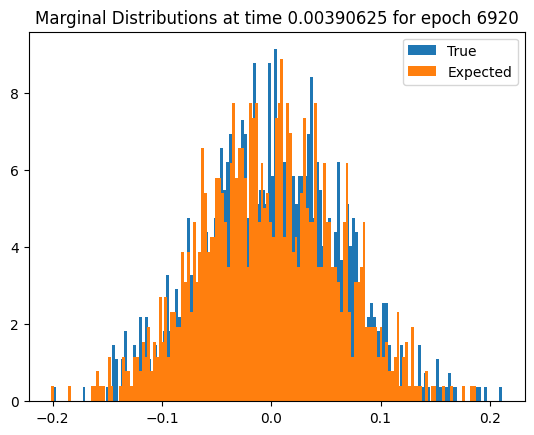

Sampling at real time 2



100%|█████████▉| 9997/10000 [03:51<00:00, 42.54it/s]

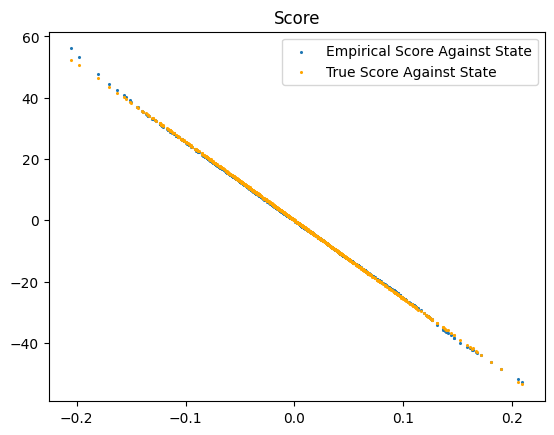

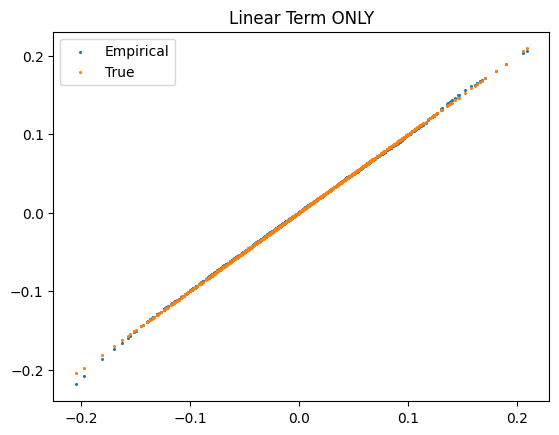

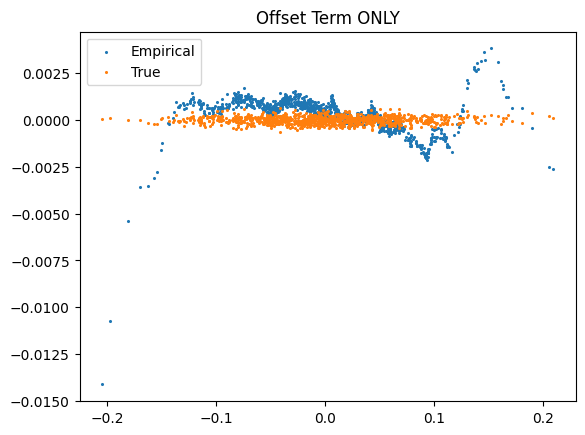

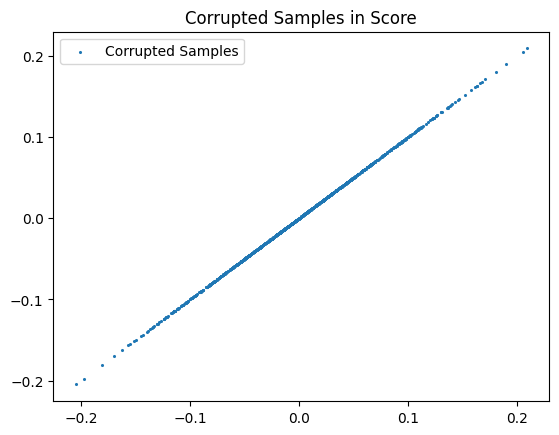

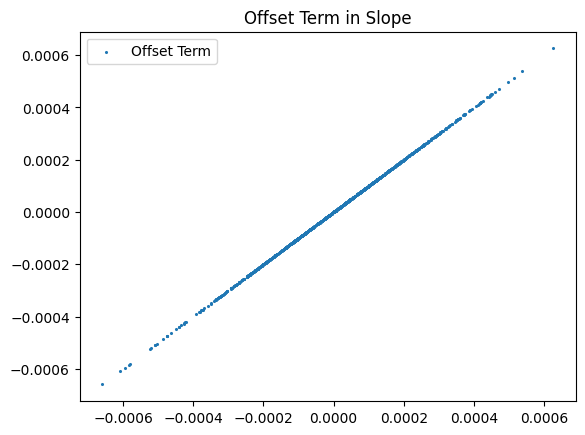

torch.Size([1000, 1]) torch.Size([1]) torch.Size([1000, 1, 1]) torch.Size([1000, 1, 1])


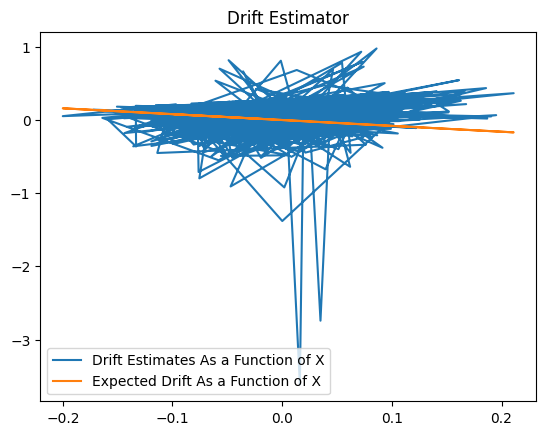

100%|██████████| 10000/10000 [03:53<00:00, 42.84it/s]


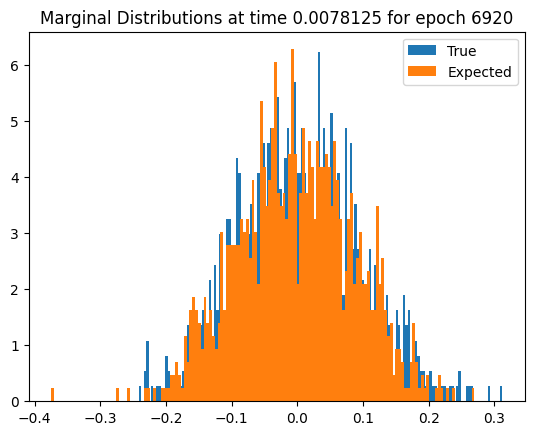

Sampling at real time 3



  7%|▋         | 739/10000 [00:17<03:38, 42.43it/s]

KeyboardInterrupt



In [71]:
initial_feature_input = torch.zeros(data_shape).to(device)
diff_time_scale = torch.linspace(start=config.end_diff_time, end=config.sample_eps,
                                   steps=config.max_diff_steps)
real_time_scale = torch.linspace(start=1/config.ts_length, end=1,
                                   steps=config.ts_length)
run_whole_ts_recursive_diffusion(config=config, initial_feature_input=initial_feature_input, diffusion=diffusion, scoreModel=scoreModel, device=device, diff_time_scale=diff_time_scale, real_time_scale=real_time_scale)